# SIMULATOR AND SUMMONER STATISTICS

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [126]:
# Load the minimum required library to run the functions
from Utils_functions import Simulator_noGPU, corr
from numpy.random import uniform
from numpy import array, int64, where, concatenate, linspace, median, sum, log, zeros, mean, var, min, max
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch
import matplotlib.pyplot as plt


In [92]:
dt = 1e-6 # The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
DeltaT = 2.5e-5 # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
Sample_frequency = 1/DeltaT # The sampling frequency. This is the number of samples that are recorded per unit time
TotalT = 0.5 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = 5
t_corr = TotalT/50

In [96]:
time_steps_amount = int64(TotalT/dt) # Number of steps
sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
t = linspace(0., TotalT,sampled_point_amount) # Time array

Chose the time characteristics of the input signal (total time, sample rate, numbero of simulations) and transform them into points info

In [74]:
prior_limits = [[1.5e4, 4e4], 
                [1e4, 140e4], 
                [3e-3, 16e-3], 
                [1.5e-2, 30e-2], 
                [1e-3, 6e-3], 
                [2e-2, 20e-2], 
                [0.5, 6], 
                [5.5, 15.5], 
                [1, 530]]    

In [88]:
# Helper function to get the priors
def get_theta_from_prior(prior_limits, n_sim):
    # Get parameters drawn from the prior
    theta = [uniform(prior_limits[i][0], prior_limits[i][1], size=(n_sim, 1)) for i in range(len(prior_limits))]
    theta_torch = torch.from_numpy(array(theta)[:,:,0].T).to(torch.float32)

    # Get the torch prior box (used in sbi)
    prior_limits = array(prior_limits)
    prior_box = utils.torchutils.BoxUniform(low=torch.tensor(prior_limits[:, 0]), high=torch.tensor(prior_limits[:, 1]))
    
    return theta, theta_torch, prior_box

In [85]:
# # prior distribution for the theta parameters
# mu_x = uniform(1.5e4, 4e4, size=(n_sim,1))
# mu_y = uniform(1e4, 140e4, size=(n_sim,1))
# k_x = uniform(3e-3, 16e-3, size=(n_sim,1))
# k_y = uniform(1.5e-2, 30e-2, size=(n_sim,1))
# k_int = uniform(1e-3, 6e-3, size=(n_sim,1))
# tau = uniform(2e-2, 20e-2, size=(n_sim,1))
# eps = uniform(0.5, 6, size=(n_sim,1))
# D_x = uniform(5.5, 15.5, size=(n_sim,1))
# D_y = uniform(1, 530, size=(n_sim,1))
# sigma = uniform(4, 260, size=(n_sim,1))

In [84]:
# mu_x = uniform(0.1, 0.5, size=(n_sim,1))
# mu_y = uniform(0.1, 0.5, size=(n_sim,1))
# k_x = uniform(0.1, 0.5, size=(n_sim,1))
# k_y = uniform(0.1, 0.5, size=(n_sim,1))
# k_int = uniform(0.1, 0.5, size=(n_sim,1))
# tau = uniform(0.1, 0.5, size=(n_sim,1))
# eps = uniform(0.1, 0.5, size=(n_sim,1))
# D_x = uniform(0.1, 0.5, size=(n_sim,1))
# D_y = uniform(0.1, 0.5, size=(n_sim,1))
# sigma = uniform(0.1, 0.5, size=(n_sim,1))

In [86]:
# theta = [mu_x, mu_y, k_x, k_y, k_int, tau, eps, D_x, D_y] # pack the parameters

In [108]:
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)

In [110]:
array(theta)[:, 1]

array([[2.25253319e+04],
       [1.04841467e+06],
       [3.21578025e-03],
       [2.37020334e-01],
       [2.08242377e-03],
       [1.08646438e-01],
       [1.62894732e+00],
       [8.73443910e+00],
       [2.92957641e+01]])

In [91]:
%%time
x_trace, f_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: user 23.5 s, sys: 17.1 ms, total: 23.5 s
Wall time: 23.6 s


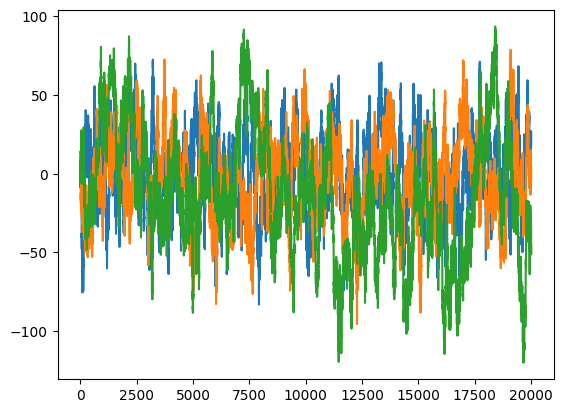

In [90]:
for i in range(3):
    plt.plot(x_trace[i,:])

Simulating the x trajectory and the f trajectory to then obtain the summary statistics, in this case the autocorrellation and the cross correllation in combination with the reduced energy production.

I don't know which formula we can pick to compute the reduce energy production, from autocorrellation, from cross correllation, all together?

ADD: Write a function GET_SUMMONER_STATISTICS() which is a list of functions, each function for a summoner statistic

In [155]:
def stat_corr(single_x_trace, single_f_trace, DeltaT):
    sampled_point_amount = single_x_trace.shape[0]
    Cxx= corr(single_x_trace, single_x_trace, sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace
    Cfx = corr(single_f_trace, single_x_trace, sampled_point_amount, dt=DeltaT) # compute the cross-correllation for each x and f trace
    Cff = corr(single_f_trace, single_f_trace, sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each f trace    

    return Cxx, Cfx, Cff

def stat_s_redx(Cxx, t_corr, t, theta_i):
    mu_x, k_x, D_x = theta_i[0], theta_i[2], theta_i[7]
    S1 = cumulative_trapezoid(Cxx, x=t, axis=-1, initial=0)
    S1 = cumulative_trapezoid(S1, x=t, axis=-1, initial=0)
    idx_corr = where((t>0)*(t<t_corr))[0]
    S_red = ((Cxx[0]-Cxx[idx_corr])+((mu_x*k_x)**2)*S1[idx_corr])/(D_x*t[idx_corr]) # compute the reduced energy production

    return S_red

def stat_s_redf(Cfx, t_corr, t, theta_i):
    mu_x, k_x, D_x = theta_i[0], theta_i[2], theta_i[7]
    idx_corr = where((t>0)*(t<t_corr))[0]
    S2f = cumulative_trapezoid(Cfx - Cfx[0], x=t, axis=-1, initial=0)
    S3f = cumulative_trapezoid(Cfx, x=t, axis=-1, initial=0)
    S3f = -mu_x*k_x*cumulative_trapezoid(S3f, x=t, axis=-1, initial=0)
    S_redf = 1-(S2f[idx_corr]+S3f[idx_corr])/(D_x*t[idx_corr]) # the energy production is to to the fluctuation-dissipation theorem
    
    return S_redf
  
def stat_psd(single_trace, k):
    frequencies, psd = welch(single_trace, fs=Sample_frequency, nperseg=sampled_point_amount/k)
    return psd

def stat_timeseries(single_timeseries):
    statistics_functions = [mean, var, median, max, min, lambda x: -sum(x*log(x)), lambda x: frequencies_x[x.argmax()]]
    s = zeros((len(statistics_functions)))

    for j, func in enumerate(statistics_functions):
        s[j] = func(single_timeseries)

    return s

In [159]:
x_trace.shape

(5, 20000)

In [179]:
a = [[1, 2, 4], [1, 2]]
a = np.concatenate(a, axis=0)

b = [[1, 2, 3], [1, 2]]
b = np.concatenate(b)


b.copy()

array([1, 2, 3, 1, 2])

In [186]:
def get_summary_statistics(list_stat, x_trace, f_trace, theta, DeltaT, k_psd):
    """
    - k_psd: number of segments to divide the signal for the psd calculation (same for x, f)
    
    """
    n_sim = x_trace.shape[0]
    theta_numpy = array(theta)

    for i in range(n_sim):
        single_x_trace = x_trace[i]
        single_f_trace = f_trace[i]
        theta_i = theta_numpy[:, 1]

        summary_i = []

        for stat in list_stat: 
            corr_dependency = False
            psdx_dependency = False
            psdf_dependency = False
            
            if stat == "Cxx" or stat == "Cfx" or stat == "Cff":
                Cxx, Cfx, Cff = stat_corr(single_x_trace, single_f_trace, DeltaT)  
                corr_dependency = True

                if stat == "Cxx": summary_i.append(Cxx)
                if stat == "Cfx": summary_i.append(Cfx)
                if stat == "Cff": summary_i.append(Cff)
            
            if stat == "s_redx":
                if corr_dependency == False:
                    Cxx, Cfx, Cff = stat_corr(single_x_trace, single_f_trace, DeltaT)
                    corr_dependency = True
                S_redx = stat_s_redx(Cxx, t_corr, t, theta_i)
                summary_i.append(S_redx)
            
            if stat == "s_redf":
                if corr_dependency == False:
                    Cxx, Cfx, Cff = stat_corr(single_x_trace, single_f_trace, DeltaT)
                    corr_dependency = True
                S_redf = stat_s_redf(Cfx, t_corr, t, theta_i)
                summary_i.append(S_redf)

            if stat == "psdx":
                psdx = stat_psd(single_x_trace, k_psd)
                psdx_dependency = True
                summary_i.append(psdx)

            if stat == "psdf":
                psdf = stat_psd(single_f_trace, k_psd)
                psdf_dependency = True
                summary_i.append(psdf)

            if stat == "ts_psdx":
                if psdx_dependency == False:
                    psdx = stat_psd(single_x_trace, k_psd)
                    psdx_dependency = True
                ts_psdx = stat_timeseries(psdx)
                summary_i.append(ts_psdx)
            
            if stat == "ts_psdf":
                if psdf_dependency == True:
                    psdf = stat_psd(single_f_trace, k_psd)
                    psdf_dependency = False
                ts_psdf = stat_timeseries(psdf)
                summary_i.append(ts_psdf)

        summary_i = np.concatenate(summary_i, axis=0)
        
        if i == 0:
            summary = summary_i.copy()
        else:
            summary = np.vstack((summary, summary_i))

    return summary


In [188]:
list_stat = ["Cxx", "s_redx", "s_redf", "psdx"]
s = get_summary_statistics(list_stat, x_trace, f_trace, theta, DeltaT, 3)
s.shape

(5, 24132)

In [132]:
Cxx, Cfx, Cff = stat_corr(x_trace[1], f_trace[1], DeltaT)
theta_i = array(theta)[:, 1]
S_red = stat_s_redx(Cxx, t_corr, t, theta_i)
S_redf = stat_s_redf(Cfx, t_corr, t, theta_i)

In [133]:
# C_xxs = []
# C_fxs = []
# S_red_all = []
# S_redf_all = []
# sum_stat_ac = []
# sum_stat_cc = []

# for i in range(n_sim):
#     Cxx= corr(x_trace[i], x_trace[i], sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace
#     Cfx = corr(f_trace[i], x_trace[i], sampled_point_amount, dt=DeltaT) # compute the cross-correllation for each x and f trace
#     C_xxs.append(Cxx)
#     C_fxs.append(Cfx)
    
#     print(Cxx.shape, t.shape)
#     S1 = cumtrapz(Cxx, x=t, axis=-1, initial=0)
#     S1 = cumtrapz(S1, x=t, axis=-1, initial=0)
#     idx_corr = where((t>0)*(t<t_corr))[0]
#     S_red = ((Cxx[0]-Cxx[idx_corr])+((mu_x[i]*k_x[i])**2)*S1[idx_corr])/(D_x[i]*t[idx_corr]) # compute the reduced energy production
#     S_red_all.append(S_red)

#     S2f = cumtrapz(Cfx - Cfx[0], x=t, axis=-1, initial=0)
#     S3f = cumtrapz(Cfx, x=t, axis=-1, initial=0)
#     S3f = -mu_x[i]*k_x[i]*cumtrapz(S3f, x=t, axis=-1, initial=0)
#     S_redf = 1-(S2f[idx_corr]+S3f[idx_corr])/(D_x[i]*t[idx_corr]) # the energy production is to to the fluctuation-dissipation theorem
#     S_redf_all.append(S_redf)

#     inputx = concatenate((Cxx[idx_corr], S_red))  # concatenate to get the summary statistics
#     sum_stat_ac.append(inputx)
#     inputf = concatenate((Cxx[idx_corr], S_redf))  # concatenate to get the summary statistics
#     sum_stat_cc.append(inputf)

# print(f"The all x autocorrellation is {C_xxs[1]}")
# print(f"The all f autocorrellation is {C_fxs[0]}")
# print(f"The reduced energy production for x is {S_red_all[0]}")
# print(f"The first summary statistic: autocorrellation of x_traces is {sum_stat_ac[0]}")
# print(f"The second summary statistic: cross-correllation of x_traces and f_traces is {sum_stat_cc[0]}")

Maybe we can select different summary statistics and usa some feature selection technique. If we use a lot of summary statistics maybe dimentionality reductions? PCA?
The idea is to use different summary statistics but to then to select the most important features of them deleting the correllations between them.

An example could be the Power spectral density for both x and f.
It can identify if there are any dominant frequencies in your data, or if the power is distributed across a range of frequencies, usefull for oscillatory behaviour

In [140]:
# psds_x = []
# psds_f = []
# for i in range(len(x_trace)):
#     frequencies_x, psd_x = welch(x_trace[i], fs=Sample_frequency, nperseg=sampled_point_amount/2)
#     frequencies_f, psd_f = welch(f_trace[i], fs=Sample_frequency, nperseg=sampled_point_amount/2)
#     psds_x.append(psd_x)
#     psds_f.append(psd_f)

We can use directly the psds as input of the neural network or we can take some statistics about each one, like mean, median, max, min,variance, entropy, frequency of top power. We can think of more statistics

In [156]:
# # Define the functions to compute the statistics
# statistics_functions = [mean, var, median, max, min, lambda x: -sum(x*log(x)), lambda x: frequencies_x[x.argmax()]]

# psds_x_statistics = zeros((len(psds_x), len(statistics_functions)))
# psds_f_statistics = zeros((len(psds_f), len(statistics_functions)))

# for i in range(len(psds_x)):
#     for j, func in enumerate(statistics_functions):
#         psds_x_statistics[i, j] = func(psds_x[i])
#         psds_f_statistics[i, j] = func(psds_f[i])

In [157]:
# print(f"The summoner statistic is {psds_x_statistics}")
# print(f"The summoner statistic is {psds_f_statistics}")

# INFERENCE STATISTICS

In [19]:
from torch import Tensor, Size
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from Utils_functions import prior_func
from numpy import squeeze

In [20]:
n_sim = 10

In [21]:
prior_dist = prior_func(num_sim = n_sim)

## thing to forget

In [23]:
# check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_dist)

In [61]:
print(f"The prior is {prior}")
print(f"The number of parameters is {num_parameters}")
print(f"The prior returns numpy is {prior_returns_numpy}")


The prior is BoxUniform(Uniform(low: torch.Size([9]), high: torch.Size([9])), 1)
The number of parameters is 9
The prior returns numpy is False


In [ ]:
# check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(Simulator_noGPU, prior, prior_returns_numpy)

In [ ]:
print(f"The simulator is {simulator}")

In [ ]:
theta = prior_dist.sample(Size((6,)))
theta.shape

Now we need to do a wrapper for the simulation since the simulator needs to take a single parameter.

In [ ]:
def simulator_wrapper(theta):
    # define the additional arguments required by the simulator function
    dt = 0.01
    DeltaT = 1
    TotalT = 100
    n_sim = 10
    # call the simulator function with the required arguments
    return Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

In [ ]:
# consistency check after making ready for sbi.
check_sbi_inputs(simulator_wrapper, prior_dist)

## True thing

In [24]:
import torch

Theta tensor shape (nsim, n_par)

In [25]:
new_theta = array(theta)[:,:,0].T

In [26]:
type(new_theta)

numpy.ndarray

In [38]:
new_theta_torch = torch.from_numpy(new_theta)
new_theta_torch = new_theta_torch.to(torch.float32)

In [28]:
new_theta_torch.shape

torch.Size([5, 9])

X same dimensions as Theta

In [37]:
sum_stat_ac = torch.from_numpy(array(sum_stat_ac))
sum_stat_ac = sum_stat_ac.to(torch.float32)

In [30]:
sum_stat_ac.shape

torch.Size([5, 39998])

In [36]:
C_xxs_torch = torch.from_numpy(array(C_xxs))

In [39]:
# check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_dist)

In [40]:
infer = SNPE(prior=prior)

In [41]:
inferece = infer.append_simulations(new_theta_torch, sum_stat_ac)

In [42]:
density_estimator = infer.train()

 Neural network successfully converged after 64 epochs.

In [43]:
posterior = infer.build_posterior(density_estimator)

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [48]:
# Get the observation
### TO FIX THE PIPELINE
dt = 1e-6 # The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
DeltaT = 2.5e-5 # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
Sample_frequency = 1/DeltaT # The sampling frequency. This is the number of samples that are recorded per unit time
TotalT = 0.5 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = 1
t_corr = 10

time_steps_amount = int64(TotalT/dt) # Number of steps
sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
t = linspace(0., TotalT,sampled_point_amount) # Time array



In [49]:
# prior distribution for the theta parameters
mu_x = uniform(1.5e4, 4e4, size=(n_sim,1))
mu_y = uniform(1e4, 140e4, size=(n_sim,1))
k_x = uniform(3e-3, 16e-3, size=(n_sim,1))
k_y = uniform(1.5e-2, 30e-2, size=(n_sim,1))
k_int = uniform(1e-3, 6e-3, size=(n_sim,1))
tau = uniform(2e-2, 20e-2, size=(n_sim,1))
eps = uniform(0.5, 6, size=(n_sim,1))
D_x = uniform(5.5, 15.5, size=(n_sim,1))
D_y = uniform(1, 530, size=(n_sim,1))
sigma = uniform(4, 260, size=(n_sim,1))

In [51]:
theta = [mu_x, mu_y, k_x, k_y, k_int, tau, eps, D_x, D_y] # pack the parameters

In [58]:
new_theta = array(theta)[:,:,0].T
new_theta_torch = torch.from_numpy(new_theta)
new_theta_torch = new_theta_torch.to(torch.float32)

In [52]:
%%time
x_trace, f_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: user 47.5 s, sys: 64.8 ms, total: 47.6 s
Wall time: 49 s


In [55]:
C_xxs = []
C_fxs = []
S_red_all = []
S_redf_all = []
sum_stat_ac = []
sum_stat_cc = []

for i in range(n_sim):
    Cxx= corr(x_trace[i], x_trace[i], sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace
    Cfx = corr(f_trace[i], x_trace[i], sampled_point_amount, dt=DeltaT) # compute the cross-correllation for each x and f trace
    C_xxs.append(Cxx)
    C_fxs.append(Cfx)
    
    S1 = cumtrapz(Cxx, x=t, axis=-1, initial=0)
    S1 = cumtrapz(S1, x=t, axis=-1, initial=0)
    idx_corr = where((t>0)*(t<t_corr))[0]
    S_red = ((Cxx[0]-Cxx[idx_corr])+((mu_x[i]*k_x[i])**2)*S1[idx_corr])/(D_x[i]*t[idx_corr]) # compute the reduced energy production
    S_red_all.append(S_red)

    S2f = cumtrapz(Cfx - Cfx[0], x=t, axis=-1, initial=0)
    S3f = cumtrapz(Cfx, x=t, axis=-1, initial=0)
    S3f = -mu_x[i]*k_x[i]*cumtrapz(S3f, x=t, axis=-1, initial=0)
    S_redf = 1-(S2f[idx_corr]+S3f[idx_corr])/(D_x[i]*t[idx_corr]) # the energy production is to to the fluctuation-dissipation theorem
    S_redf_all.append(S_redf)

    inputx = concatenate((Cxx[idx_corr], S_red))  # concatenate to get the summary statistics
    sum_stat_ac.append(inputx)
    inputf = concatenate((Cxx[idx_corr], S_redf))  # concatenate to get the summary statistics
    sum_stat_cc.append(inputf)

print(f"The all x autocorrellation is {C_xxs[0]}")
print(f"The all f autocorrellation is {C_fxs[0]}")
print(f"The reduced energy production for x is {S_red_all[0]}")
print(f"The first summary statistic: autocorrellation of x_traces is {sum_stat_ac[0]}")
print(f"The second summary statistic: cross-correllation of x_traces and f_traces is {sum_stat_cc[0]}")

The all x autocorrellation is [ 2.99858152e+03  2.99184064e+03  2.98524361e+03 ... -2.04460480e-02
 -1.18858406e-02 -3.34625521e-03]
The all f autocorrellation is [1.79205963e+01 1.79125542e+01 1.79039919e+01 ... 1.41718247e-02
 9.56249650e-03 4.96563964e-03]
The reduced energy production for x is [23847.12211717 23625.228532   23570.42939883 ... 16741.59938728
 16740.76071135 16739.92212291]
The first summary statistic: autocorrellation of x_traces is [ 2991.84063759  2985.24360959  2978.64850275 ... 16741.59938728
 16740.76071135 16739.92212291]
The second summary statistic: cross-correllation of x_traces and f_traces is [2991.84063759 2985.24360959 2978.64850275 ...  -11.98052162  -11.98033225
  -11.98014288]


/tmp/ipykernel_24921/2853972545.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  S1 = cumtrapz(Cxx, x=t, axis=-1, initial=0)
/tmp/ipykernel_24921/2853972545.py:15: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  S1 = cumtrapz(S1, x=t, axis=-1, initial=0)
/tmp/ipykernel_24921/2853972545.py:20: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  S2f = cumtrapz(Cfx - Cfx[0], x=t, axis=-1, initial=0)
/tmp/ipykernel_24921/2853972545.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  S3f = cumtrapz(Cfx, x=t, axis=-1, initial=0)
/tmp/ipykernel_24921/2853972545.py:22: DeprecationWarn

In [57]:
sum_stat_ac = torch.from_numpy(array(sum_stat_ac))
sum_stat_ac = sum_stat_ac.to(torch.float32)

In [60]:
samples = posterior.sample((100, ), x=sum_stat_ac)
_ = analysis.pairplot(samples, points=new_theta_torch)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    100 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 